# Import necessary libraries and load the dataset #

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pandas nltk textblob gensim wordcloud matplotlib
import nltk
import re
from collections import Counter
from textblob import TextBlob
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud


[notice] A new release of pip available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
file_path = "C:\\Users\\zhi-n\\Documents\\FIT3163\\mimic-iv-note\\discharge.csv"
data = pd.read_csv(file_path)

# Overview of Data #

In [3]:
data.head(5)

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000032-DS-21,10000032,22595853,DS,21,2180-05-07 00:00:00,2180-05-09 15:26:00,\nName: ___ Unit No: _...
1,10000032-DS-22,10000032,22841357,DS,22,2180-06-27 00:00:00,2180-07-01 10:15:00,\nName: ___ Unit No: _...
2,10000032-DS-23,10000032,29079034,DS,23,2180-07-25 00:00:00,2180-07-25 21:42:00,\nName: ___ Unit No: _...
3,10000032-DS-24,10000032,25742920,DS,24,2180-08-07 00:00:00,2180-08-10 05:43:00,\nName: ___ Unit No: _...
4,10000084-DS-17,10000084,23052089,DS,17,2160-11-25 00:00:00,2160-11-25 15:09:00,\nName: ___ Unit No: __...


In [4]:
df = pd.DataFrame(data)
# Set the display option to show the full content of the 'text' column
pd.set_option('display.max_colwidth', None)
# Display the top 5 rows of the DataFrame
df[['note_id', 'text']].head(1)

note_id  \
0  10000032-DS-21   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

# Data Pre-processing #

### Summary of Data ###

#### 1. Number of Records  ####

In [5]:
num_records, num_columns = data.shape

print(f"The dataset contains {num_records} records and {num_columns} columns.")

The dataset contains 331794 records and 8 columns.


#### 2. Data Types  ####

In [6]:
data_types = data.dtypes
print("Data types of each feature:")
print(data_types)

Data types of each feature:
note_id       object
subject_id     int64
hadm_id        int64
note_type     object
note_seq       int64
charttime     object
storetime     object
text          object
dtype: object


# Data Analysis #

#### Checking for Inconsistencies, missing values  ####

In [7]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

note_id        0
subject_id     0
hadm_id        0
note_type      0
note_seq       0
charttime      0
storetime     17
text           0
dtype: int64


In [8]:
# Drop Missing Values
data.dropna(subset=['storetime'], inplace=True)

In [9]:
# Check for Duplicate Records
duplicate_rows = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


### Analyzing the 'text' column, by experimenting with subset of data ###

#### Step 1: Data Preparation ###

In [10]:
subset = data.sample(n=1)

In [11]:
# Data Cleaning
# 1. Remove special characters, numbers, and unwanted white spaces
import re

def clean_text(text):
    # Removing special characters and numbers
    text = re.sub('[^A-Za-z\s]', '', text)
    # Removing extra white spaces
    text = re.sub('\s+', ' ', text).strip()
    return text

subset['cleaned_text'] = subset['text'].apply(clean_text)

# 2. Convert all the text to lowercase
subset['cleaned_text'] = subset['cleaned_text'].str.lower()

# 3. Remove stopwords using SpaCy
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOP_WORDS])

subset['cleaned_text'] = subset['cleaned_text'].apply(remove_stopwords)

# Display the cleaned text
subset[['cleaned_text']].head(1)

cleaned_text
45368  unit admission date discharge date date birth sex f service medicine allergies penicillins attending chief complaint abnormal labs major surgical invasive procedure upper endoscopy history present illness ms ho tobacco use hypothyroidism presenting pcp acute anemia hb recent prior hgb nl setting month history loss appetite nausea vomiting lbs weight loss months pt states went pcp evaluation wt loss anemia discovered wu wt loss pcps office states felt dizzy sxs appetite recently states smells bad endorses nonbloody emesis x m denies sob cp abd pain cough diarrhea bloody black stools notes date colonoscopy pap smear followed breast cysts reportedly biopsies past negative ed initial vitals ra pressures dropped systolic improved time transfer rectal exam notably heme neg labs notable crit u prbcs plts ast ldh iron ferritin normal hapto nl bili ct cap showed small moderate bilat pleural effusions nodular breast tissue mm pulm nodule floor pt complaints tells started mirtazipine yesterday expresses concerns dust apartment causing asthma flare occasion states generally controlled review systems hpi denies fever chills night sweats denies headache sinus tenderness rhinorrhea congestion denies cough shortness breath denies chest pain tightness palpitations denies diarrhea constipation abdominal pain recent change bowel bladder habits dysuria denies arthralgias myalgias pt ros negative past medical history asthmasmoker breast cystsmultiple biopsiesfollowed years ago malignant depression fibromyalgia hypothyroidism migraine headaches anorexia restless leg social history family history mother died father physical exam admission vitals constitutional alert oriented acute distress thin eyes sclera anicteric eomi perrl enmt mmm oropharynx clear normal hearing normal nares neck supple lad cv regular rate rhythm normal s s murmurs rubs gallops respiratory clear auscultation bilaterally wheezes rales rhonchi gi soft nontender nondistended bowel sounds present organomegaly rebound guarding gu foley ext warm perfused cce lad neuro aaox cniixii strength grossly intact skin rashes lesions discharge ra gen elderly female nad heent mmm eomi perrla breast exam fibrocystic tissue masses lad cellulitic changes cv rrr apprec m resp moving air today appreciated wr abd soft nd nabs ttp gu foley extr warm edema neuro alert appropriate cn intact strength bilaterally upper extremities ble sensation intact fnf intact bilaterally ram intact pronator drift psych normal affect pertinent results admission pm blood wbc rbc hgb hct mcv mch mchc rdw rdwsd plt pm blood neuts lymphs monos eos baso im absneut abslymp absmono abseos absbaso blood ret aut abs ret pm blood pm blood urean creat na k cl hco angap pm blood alt ast alkphos totbili blood albumin calcium phos mg iron blood caltibc ferritn trf pm blood triglyc hdl cholhd ldlcalc pm blood tsh blood free t blood lactate ct chest abd pelv small moderate bilateral pleural effusions compressive atelectasis left lung base interstitial edema evidence hemorrhage hematoma imaged torso somewhat nodular appearance tissue right breast potentially breast tissue underlying soft tissue nodules possible correlation prior mammograms outpatient followup diagnostic mammogram recommended evaluation previously performed mm right lower lobe pulmonary nodule upper endoscopy lower esophageal exudates vs sloughing biopsied erosions stomach body ulcers erosions antrum biopsied duodenitis biopsied looping prevented pushing portion duodenum ttg normal biopsies egd returned positive hpylori pt updated phone ho tobacco use symptomatic hypothyroidism ptsdanxiety pw acute anemia setting nausea vomiting lbs weight loss pt found elevated tsh ldh multiple erosions gastrum duodenum egd biopsies returned positive hpylori discharge acute chronic blood loss anemia iron deficiency likely gi blood loss multiple erosionsgastritis seen egd pt treated supportively blood transfusions oral iron replacement ppi bid resolution gi symptoms d

##### Tokenization ##### 

In [12]:
!python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")


[notice] A new release of pip available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 12.8/12.8 MB 4.9 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [13]:
# Step 1: Tokenization
subset['tokenized_text'] = subset['cleaned_text'].apply(lambda x: [token.text for token in nlp(x)])
subset[['tokenized_text']].head(1) 


,tokenized_text
45368,"[unit, admission, date, discharge, date, date, birth, sex, f, service, medicine, allergies, penicillins, attending, chief, complaint, abnormal, labs, major, surgical, invasive, procedure, upper, endoscopy, history, present, illness, ms, ho, tobacco, use, hypothyroidism, presenting, pcp, acute, anemia, hb, recent, prior, hgb, nl, setting, month, history, loss, appetite, nausea, vomiting, lbs, weight, loss, months, pt, states, went, pcp, evaluation, wt, loss, anemia, discovered, wu, wt, loss, pcps, office, states, felt, dizzy, sxs, appetite, recently, states, smells, bad, endorses, nonbloody, emesis, x, m, denies, sob, cp, abd, pain, cough, diarrhea, bloody, black, stools, notes, date, colonoscopy, pap, smear, followed, breast, cysts, reportedly, biopsies, ...]"


##### Lemmatization ##### 

In [14]:
# Step 2: Lemmatization
# Summarization can benefit from this step as it can reduce the diversity of terms to their root forms, making processing more uniform.
import nltk
nltk.download('omw-1.4')
subset['lemmatized_text'] = subset['tokenized_text'].apply(lambda x: [token.lemma_ for token in nlp(' '.join(x))])
subset[['lemmatized_text']].head(1) 



[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\zhi-n\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,lemmatized_text
45368,"[unit, admission, date, discharge, date, date, birth, sex, f, service, medicine, allergie, penicillin, attend, chief, complaint, abnormal, lab, major, surgical, invasive, procedure, upper, endoscopy, history, present, illness, ms, ho, tobacco, use, hypothyroidism, present, pcp, acute, anemia, hb, recent, prior, hgb, nl, set, month, history, loss, appetite, nausea, vomit, lbs, weight, loss, month, pt, state, go, pcp, evaluation, wt, loss, anemia, discover, wu, wt, loss, pcps, office, state, feel, dizzy, sxs, appetite, recently, states, smell, bad, endorse, nonbloody, emesis, x, m, denies, sob, cp, abd, pain, cough, diarrhea, bloody, black, stool, note, date, colonoscopy, pap, smear, follow, breast, cyst, reportedly, biopsy, ...]"


#### Data Analysis ####

#### 1. Word Frequency ####

In [15]:
# Visualizing word frequencies
all_words = [word for tokens in subset['tokenized_text'] for word in tokens]
word_freq = Counter(all_words)
print(word_freq.most_common(10))  # Display the 10 most common words

[('mg', 20), ('po', 19), ('pt', 18), ('blood', 18), ('discharge', 14), ('loss', 11), ('weight', 10), ('breast', 9), ('anemia', 7), ('denies', 7)]


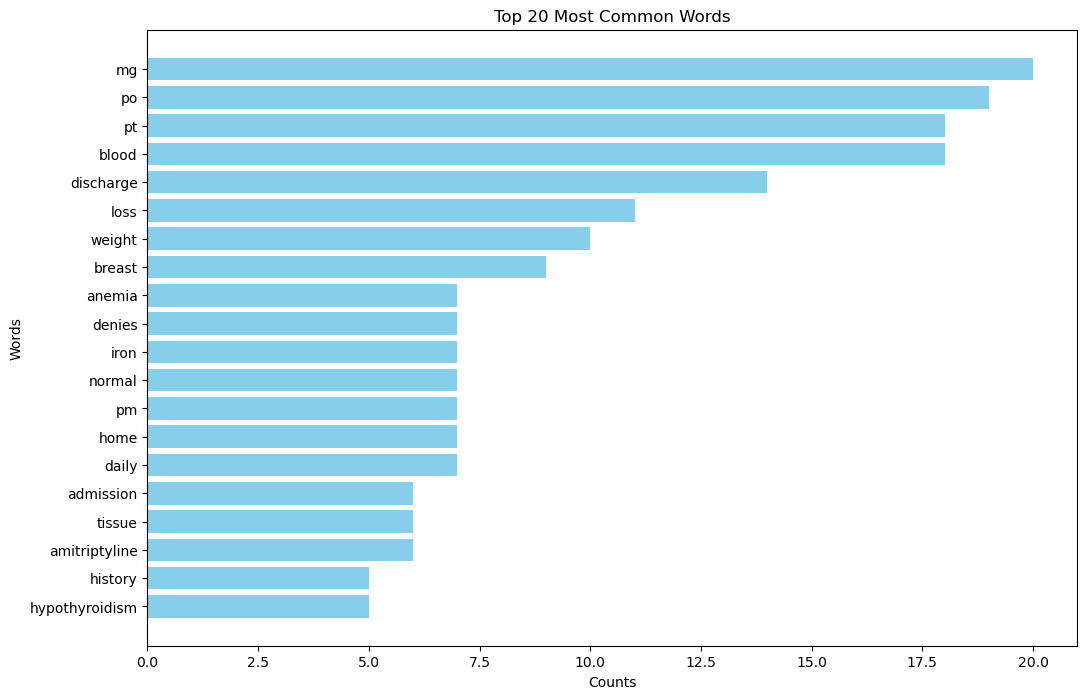

In [16]:
import matplotlib.pyplot as plt

# Extract the 20 most common words and their counts
common_words = word_freq.most_common(20)

# Split words and their counts into separate lists
words = [word[0] for word in common_words]
counts = [word[1] for word in common_words]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Counts')
plt.ylabel('Words')
plt.title('Top 20 Most Common Words')
plt.gca().invert_yaxis()  # This ensures the most common word is at the top
plt.show()

#### 2. N-gram Analysis ####

Top 10 Most Common Bigrams:
'mg po': 15
'pm blood': 7
'weight loss': 6
'po qhs': 4
'amitriptyline mg': 4
'po daily': 4
'upper endoscopy': 3
'loss anemia': 3
'pleural effusions': 3
'breast tissue': 3


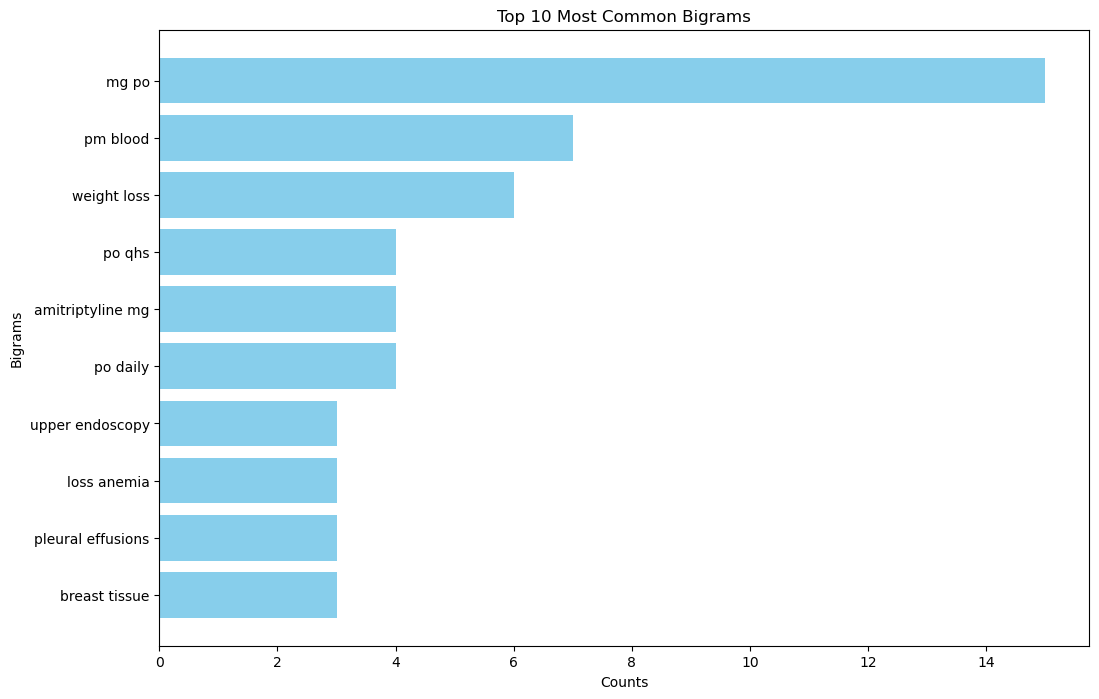

In [17]:
# look at the frequency of two or three word phrases (bigrams or trigrams). 
# This can provide insight into common phrases or topics.
from nltk import ngrams

bigrams = [bigram for tokens in subset['tokenized_text'] for bigram in ngrams(tokens, 2)]
bigram_freq = Counter(bigrams)

# Top 10 bigrams
common_bigrams = bigram_freq.most_common(10)
bigram_words = [' '.join(word[0]) for word in common_bigrams]
bigram_counts = [word[1] for word in common_bigrams]

# Print the top 10 bigrams in text format
print("Top 10 Most Common Bigrams:")
for bigram, count in common_bigrams:
    print(f"'{' '.join(bigram)}': {count}")

plt.figure(figsize=(12,8))
plt.barh(bigram_words, bigram_counts, color='skyblue')
plt.title('Top 10 Most Common Bigrams')
plt.xlabel('Counts')
plt.ylabel('Bigrams')
plt.gca().invert_yaxis()
plt.show()

#### 3. POS (Part-of-Speech) Tagging ####


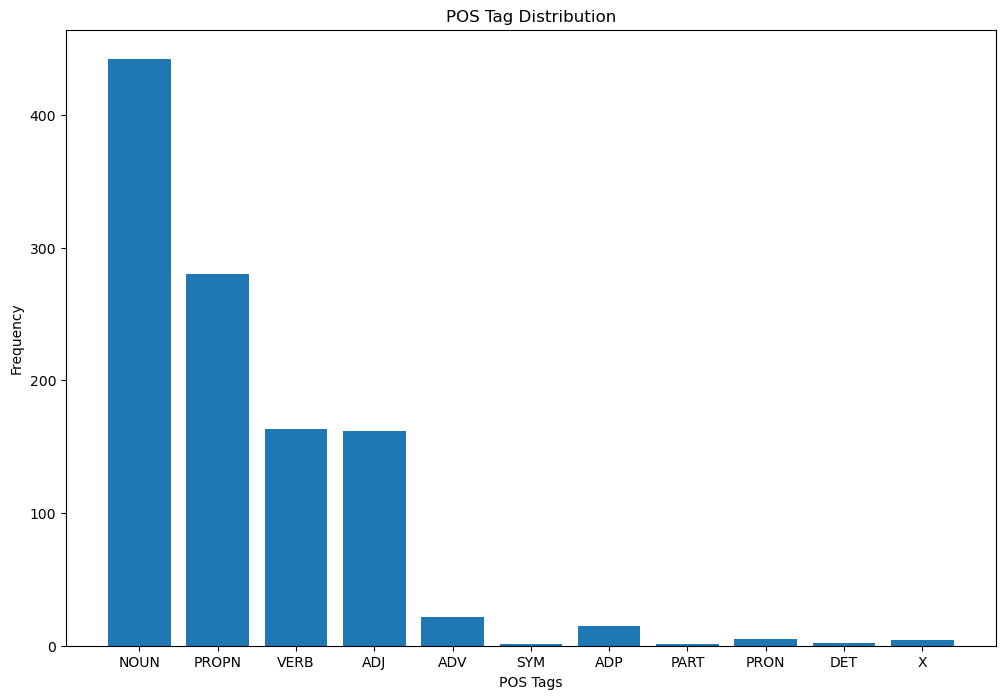

In [18]:
# The identification of words as nouns, verbs, adjectives, adverbs,
pos_tags = [token.pos_ for text in subset['tokenized_text'] for token in nlp(' '.join(text))]
pos_freq = Counter(pos_tags)

plt.figure(figsize=(12, 8))
plt.bar(pos_freq.keys(), pos_freq.values())
plt.title("POS Tag Distribution")
plt.xlabel("POS Tags")
plt.ylabel("Frequency")
plt.show()

#### 4. TF-IDF Analysis ####

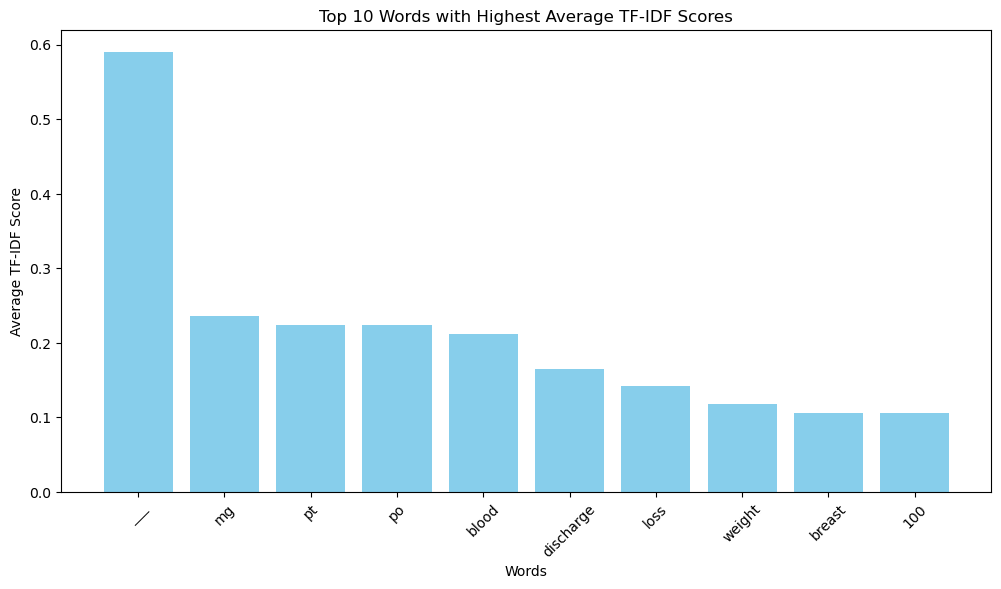


Top 10 Words with Highest Average TF-IDF Scores:
Word: ___, TF-IDF Score: 0.5902
Word: mg, TF-IDF Score: 0.2361
Word: pt, TF-IDF Score: 0.2243
Word: po, TF-IDF Score: 0.2243
Word: blood, TF-IDF Score: 0.2125
Word: discharge, TF-IDF Score: 0.1652
Word: loss, TF-IDF Score: 0.1416
Word: weight, TF-IDF Score: 0.1180
Word: breast, TF-IDF Score: 0.1062
Word: 100, TF-IDF Score: 0.1062


In [19]:
# determine the significance of words in a document or corpus
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Use the TF-IDF vectorizer without setting max_df
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(subset['text'])
feature_names = vectorizer.get_feature_names_out()

# Calculate average TF-IDF scores for each term
avg_tfidf_scores = np.mean(tfidf_matrix, axis=0).tolist()[0]
sorted_indices = np.argsort(avg_tfidf_scores)[::-1][:10]

# Plot the top 10 terms
plt.figure(figsize=(12,6))
plt.bar(np.array(feature_names)[sorted_indices], np.array(avg_tfidf_scores)[sorted_indices], color='skyblue')
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Average TF-IDF Score")
plt.title("Top 10 Words with Highest Average TF-IDF Scores")
plt.show()

# Print the top 10 words with their scores
print("\nTop 10 Words with Highest Average TF-IDF Scores:")
for idx in sorted_indices:
    print(f"Word: {feature_names[idx]}, TF-IDF Score: {avg_tfidf_scores[idx]:.4f}")

### Analyzing the 'text' column (Full Data) and Visualization